In [3]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
import sys
from PIL import Image, ImageDraw, ImageFont
import json
import cv2
import os
import time
import tensorflow as tf
from keras import layers, Input, models, optimizers
from keras.models import Model, Sequential
from keras.models import load_model

In [33]:
def style_n_pattern(img_dir, 
                    model_pattern, var_pattern, 
                    model_style, var_style, 
                    model_shape, var_shape,
                    file_name):
    
    
    # 1) 사용할 model 설정
    model_pattern = load_model(model_pattern)    # pattern model
    model_style = load_model(model_style)        # style model
    model_shape = load_model(model_shape)
    
    # 2) 카카오 API 설정
    API_URL = 'https://kapi.kakao.com/v1/vision/product/detect'
    MYAPP_KEY = '890ebefd9a013403b1c6e290024eb8a3'
    #'89b7d96fc38f45fbf6ca52c2b13d2ad8'
    url = "https://kapi.kakao.com/v1/vision/product/detect"       
    headers = {'Authorization': 'KakaoAK {}'.format(MYAPP_KEY)}
    files = { 'file' : open(img_dir, 'rb')}
    response = requests.post(url, headers=headers, files=files)
    
    
    # 3) 카카오 API 저장 및 예외 상황 설정
    info = []
    result = response.json()
    
    if 'result' in result:                                                    # 카카오API가 이미지 인식 못하는 경우 stop
        fig_w, fig_h = result['result']['width'], result['result']['height']
    else:
        return ['NA','NA','NA','NA','NA']

    if 'objects' in result['result']:
        mylist = result['result']['objects']
        cnt = 0
        for objects in mylist:
            if objects['class'] in ['shirts','t-shirts','outer','pants','skirt']:
                cnt = cnt+1
        if cnt != 2:
            return ['NA','NA','NA','NA','NA']
    else:
        return ['NA','NA','NA','NA','NA']
        
    for each in result['result']['objects']:                        
            each = list(each.values())                                             # 순서 : x1, y1, x2, y2, class
            info.append(each)      
    
    
    # 4) 사진 상하의 구분 및 pattern, style 예측
    top_pattern = []
    bottom_pattern = []
    top_shape = []
    bottom_shape = []
    
    for _ in range(len(info)):
        img = Image.open(img_dir)
        category = info[_][4]

        if category in ('shirts','t-shirts','outer'):
            x = info[_][0]*fig_w - 5
            y = info[_][1]*fig_h - 5
            w = info[_][2]*fig_w + 5
            h = info[_][3]*fig_h + 5
            path = 'C:/python_DA/파이널프로젝트/img/cropped_img/top/'         # 이미지 저장 코드     
            img = img.crop((x,y,w,h))                               
            plt.imshow(img)
            img.show() 
            img.save(str(path + 'top_' + file_name))                                   # 이미지 저장 코드

            img = img.resize((150,150))
            data = np.array(img)
            data = data.astype('float')
            data = data/255
            data = data.reshape((1,150,150,3))
            
            # top pattern 예측
            p = var_pattern[model_pattern.predict_classes(data)[0]]
            top_pattern.append(p)
            
            # top shape 예측
            s = var_shape[model_shape.predict_classes(data)[0]]
            top_shape.append(s)
            
            
        elif category in ('pants','skirt'): 
            x = info[_][0]*fig_w - 5
            y = info[_][1]*fig_h - 5
            w = info[_][2]*fig_w + 5
            h = info[_][3]*fig_h + 5
            path = 'C:/python_DA/파이널프로젝트/img/cropped_img/bottom/'        # 이미지 저장 코드 
            img = img.crop((x,y,w,h))                               
            plt.imshow(img)
            img.show()
            img.save(str(path + 'bottom_' +file_name))                          # 이미지 저장 코드

            img = img.resize((150,150))
            data = np.array(img)
            data = data.astype('float')
            data = data/255
            data = data.reshape((1,150,150,3))
            
            # bottom pattern 예측
            p = var_pattern[model_pattern.predict_classes(data)[0]]
            bottom_pattern.append(p)
            
            # bottom shape 예측
            s = var_shape[model_shape.predict_classes(data)[0]]
            bottom_shape.append(s)
            
            
            
    # 5) 사진 전체의 style 예측 
    img = Image.open(img_dir)
    img = img.resize((150,150))
    data = np.array(img)
    data = data.astype('float')
    data = data/255
    data = data.reshape((1,150,150,3))
    style = [var_style[model_style.predict_classes(data)[0]]]

    
    # 6)예측값이 없는 경우는 'NA' 값으로 표기
    if len(top_pattern) == 0:
        top_pattern = ['NA']
    if len(bottom_pattern) == 0:
        bottom_pattern = ['NA']
    if len(style) == 0:
        style = ['NA']
    if len(top_shape) == 0:
        top_shape = ['NA']
    if len(bottom_shape) == 0:
        bottom_shape = ['NA']
    
    return ( style + top_pattern + bottom_pattern + top_shape + bottom_shape )


In [35]:
def predict_multi(folder_dir, model_pattern, var_pattern, model_style, var_style, model_shape, var_shape):
    
    file_list = os.listdir(folder_dir)
    df = pd.DataFrame(index=range(0,0), 
                      columns=['img','style','top pattern','bottom pattern','top shape','bottom shape'])
    
    for _ in range(len(file_list)):
        img_dir = folder_dir + '/' + file_list[_]
        Image.open(img_dir)
        
        file_name = file_list[_]
        k = style_n_pattern(img_dir,
                            model_pattern, var_pattern, 
                            model_style, var_style, 
                            model_shape, var_shape,
                            file_name)   
        
        # file_name = 상하의 구분해서 저장할때 사용할 이름: 기존 사진 이름과 동일하게 저장하기 위함
        
        total = [file_list[_]] + k
        df.loc[_] = total
        display(df)
    return df


2


,img,style,top pattern,bottom pattern,top shape,bottom shape
0,0 (1).jpg,casual,dot,none,Tee,Tee


2


,img,style,top pattern,bottom pattern,top shape,bottom shape
0,0 (1).jpg,casual,dot,none,Tee,Tee
1,0 (2).jpg,casual,check,none,Sweater,Jeans


2


,img,style,top pattern,bottom pattern,top shape,bottom shape
0,0 (1).jpg,casual,dot,none,Tee,Tee
1,0 (2).jpg,casual,check,none,Sweater,Jeans
2,0 (3).jpg,feminine,dot,none,Tee,Sweater


0


,img,style,top pattern,bottom pattern,top shape,bottom shape
0,0 (1).jpg,casual,dot,none,Tee,Tee
1,0 (2).jpg,casual,check,none,Sweater,Jeans
2,0 (3).jpg,feminine,dot,none,Tee,Sweater
3,0 (4).jpg,NA,NA,NA,NA,NA


2


,img,style,top pattern,bottom pattern,top shape,bottom shape
0,0 (1).jpg,casual,dot,none,Tee,Tee
1,0 (2).jpg,casual,check,none,Sweater,Jeans
2,0 (3).jpg,feminine,dot,none,Tee,Sweater
3,0 (4).jpg,NA,NA,NA,NA,NA
4,0 (5).jpg,casual,none,none,Tee,Tee


2


,img,style,top pattern,bottom pattern,top shape,bottom shape
0,0 (1).jpg,casual,dot,none,Tee,Tee
1,0 (2).jpg,casual,check,none,Sweater,Jeans
2,0 (3).jpg,feminine,dot,none,Tee,Sweater
3,0 (4).jpg,NA,NA,NA,NA,NA
4,0 (5).jpg,casual,none,none,Tee,Tee
5,0 (6).jpg,casual,stripe,none,Jacket,Jeans


2


,img,style,top pattern,bottom pattern,top shape,bottom shape
0,0 (1).jpg,casual,dot,none,Tee,Tee
1,0 (2).jpg,casual,check,none,Sweater,Jeans
2,0 (3).jpg,feminine,dot,none,Tee,Sweater
3,0 (4).jpg,NA,NA,NA,NA,NA
4,0 (5).jpg,casual,none,none,Tee,Tee
5,0 (6).jpg,casual,stripe,none,Jacket,Jeans
6,0 (7).jpg,casual,none,none,Tee,Tee


2


,img,style,top pattern,bottom pattern,top shape,bottom shape
0,0 (1).jpg,casual,dot,none,Tee,Tee
1,0 (2).jpg,casual,check,none,Sweater,Jeans
2,0 (3).jpg,feminine,dot,none,Tee,Sweater
3,0 (4).jpg,NA,NA,NA,NA,NA
4,0 (5).jpg,casual,none,none,Tee,Tee
5,0 (6).jpg,casual,stripe,none,Jacket,Jeans
6,0 (7).jpg,casual,none,none,Tee,Tee
7,0 (8).jpg,casual,dot,dot,Tee,Jacket


2


,img,style,top pattern,bottom pattern,top shape,bottom shape
0,0 (1).jpg,casual,dot,none,Tee,Tee
1,0 (2).jpg,casual,check,none,Sweater,Jeans
2,0 (3).jpg,feminine,dot,none,Tee,Sweater
3,0 (4).jpg,NA,NA,NA,NA,NA
4,0 (5).jpg,casual,none,none,Tee,Tee
5,0 (6).jpg,casual,stripe,none,Jacket,Jeans
6,0 (7).jpg,casual,none,none,Tee,Tee
7,0 (8).jpg,casual,dot,dot,Tee,Jacket
8,0 (9).jpg,casual,check,none,Jacket,Jeans


,img,style,top pattern,bottom pattern,top shape,bottom shape
0,0 (1).jpg,casual,dot,none,Tee,Tee
1,0 (2).jpg,casual,check,none,Sweater,Jeans
2,0 (3).jpg,feminine,dot,none,Tee,Sweater
3,0 (4).jpg,NA,NA,NA,NA,NA
4,0 (5).jpg,casual,none,none,Tee,Tee
5,0 (6).jpg,casual,stripe,none,Jacket,Jeans
6,0 (7).jpg,casual,none,none,Tee,Tee
7,0 (8).jpg,casual,dot,dot,Tee,Jacket
8,0 (9).jpg,casual,check,none,Jacket,Jeans


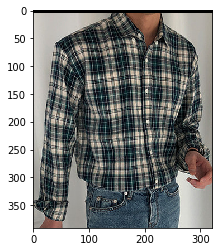

In [37]:
folder_dir = 'C:/python_DA/파이널프로젝트/img/test'

model_pattern = 'C:/python_DA/파이널프로젝트/model/pattern_no_camo_정확도76.h5'
var_pattern = ['check', 'dot', 'floral', 'graphic', 'leopard', 'none', 'stripe', 'tribal']  

model_style = 'C:/python_DA/파이널프로젝트/model/model_style_3개_90%_63%.h5'
var_style = ['casual', 'feminine', 'formal']

model_shape = 'C:/python_DA/파이널프로젝트/model/clothes_category_small_2.h5'
var_shape = ['Coat','Cutoffs','Hoodie','Jacket','Jeans','Poncho','Sarong','Shirts','Skirt','Sweater','Tee']


predict_multi(folder_dir, 
              model_pattern, var_pattern, 
              model_style, var_style, 
              model_shape, var_shape)
